# Homework 3. Movie review sentiment analysis

by Sofia Shchipinskaya

In [2]:
# importing libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve, GridSearchCV
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import word2vec

### Loading and looking through the data

In [3]:
# loading the data
data_sub = pd.read_csv("sampleSubmission.csv")
data_train = pd.read_csv("train.tsv", sep="\t")
data_test = pd.read_csv("test.tsv", sep="\t")

In [3]:
# looking through the train data
data_train.shape[0]

156060

In [4]:
# looking through the train data
data_train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,a story,2
61,62,1,story,2
62,63,1,.,2
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3


In [5]:
# looking through the train data
print('Checking sample imbalance problem of train data')
print(data_train['Sentiment'].value_counts())
print(data_train['Sentiment'].value_counts(normalize=True))

Checking sample imbalance problem of train data
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64
2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64


#### comment
As we can see, the train data is not balanced, so we have a sample imbalance problem here

In [6]:
# looking through the test data
data_test.head(5)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [7]:
# looking through the sampleSubmission data
data_sub.head(5)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [8]:
# looking through the sampleSubmission data
print(data_sub['Sentiment'].value_counts())

2    66292
Name: Sentiment, dtype: int64


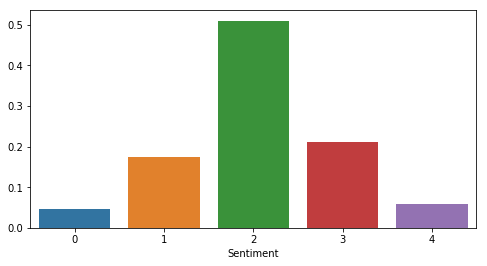

In [9]:
# constructing a graph
dist = data_train.groupby(["Sentiment"]).size()
dist = dist/dist.sum()
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(dist.keys(), dist.values);

#### comment
Actualy, to biuld models with better performance it is needed to solve sample imbalance problem (for instance, to do undersampling of majority class or oversampling of minority class). Unfortunately, I had some problems with Anaconda and spent almost 2 days trying to solve them. So, I didn't solve sample imbalance problem here, naybe thats why the models show poor performance.

Also, for checking model performance I chose f1-score metrics because it somehow deals with sample imbalance problem. 

### Classical approach

#### Vectorizing data

In [10]:
# tfidf 
train = data_train
train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,a story,2
61,62,1,story,2
62,63,1,.,2
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3


In [11]:
phrase = train['Phrase']
phrase.head(2)

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
Name: Phrase, dtype: object

In [12]:
# tfidf 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X = tfidf.fit_transform(phrase)
Y = train['Sentiment']
X.shape

(156060, 54911)

In [13]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#### Logistic regression and Random forest

In [14]:
# Logistic regression
LR = LogisticRegression(random_state=0)
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
print(classification_report(y_test, LR_pred))

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.17      0.27      1416
           1       0.55      0.30      0.39      5527
           2       0.64      0.91      0.75     15639
           3       0.59      0.43      0.50      6707
           4       0.65      0.21      0.32      1923

   micro avg       0.62      0.62      0.62     31212
   macro avg       0.62      0.40      0.45     31212
weighted avg       0.61      0.62      0.58     31212



In [15]:
# Random forest
RF = RandomForestClassifier(n_estimators=50, max_depth=70)
RF.fit(X_train, y_train)
RF_pred = RF.predict(X_test)
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.72      0.04      0.07      1416
           1       0.58      0.02      0.05      5527
           2       0.51      0.99      0.68     15639
           3       0.56      0.04      0.07      6707
           4       0.73      0.05      0.10      1923

   micro avg       0.52      0.52      0.52     31212
   macro avg       0.62      0.23      0.19     31212
weighted avg       0.56      0.52      0.37     31212



#### Tuning models

In [16]:
# logistic regression tuning
LR_parameters = {'penalty': ['l1', 'l2'],'C': [0.0001, 0.001, 0.01, 1, 100]}
LR_tun = GridSearchCV(LR, LR_parameters, scoring = 'f1_weighted', cv = 8)
LR_tun.fit(X_train, y_train)
LR_tun.best_estimator_
print("Best LR parameters:", LR_tun.best_params_, "Best score:", LR_tun.best_score_)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Best LR parameters: {'C': 100, 'penalty': 'l2'} Best score: 0.622180076772519


/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
# random forest tuning
RF_parameters = {'n_estimators': [10, 50, 100],'max_depth': [10, 70]}
RF_tun = GridSearchCV(RF, RF_parameters, scoring = 'f1_weighted', cv = 5)
RF_tun.fit(X_train, y_train)
RF_tun.best_estimator_
print("Best RF parameters:", RF_tun.best_params_, "Best score:", RF_tun.best_score_)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Best RF parameters: {'max_depth': 70, 'n_estimators': 10} Best score: 0.40036319279380717


#### comment
So, after grid search the best model f1-score for both models:
- logistic regression f1-score = 62.21%
- random forest f1-score = 40.03%

### Word2vec approach

#### Cleaning data
Firstly we need to remove digits and punctuation and then check for empty phrases. We need to do this first because some sentences consist only of punctuation marks or digits, so after deleting them these phrases are going to be empty ones.

In [4]:
# lowercase trandformation
data_train['Phrase'] = data_train['Phrase'].map(lambda x: x.lower())
data_train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,a story,2
61,62,1,story,2
62,63,1,.,2
63,64,2,"this quiet , introspective and entertaining in...",4
64,65,2,"this quiet , introspective and entertaining in...",3


In [5]:
# removing punctuation
data_train['Phrase'] = data_train['Phrase'].str.replace('[^\w\s]', '')
data_train.iloc[60:66]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,a story,2
61,62,1,story,2
62,63,1,,2
63,64,2,this quiet introspective and entertaining ind...,4
64,65,2,this quiet introspective and entertaining ind...,3
65,66,2,this,2


In [6]:
# removing digits
data_train['Phrase'] = data_train['Phrase'].str.replace('[0-9]', '')
data_train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,a story,2
61,62,1,story,2
62,63,1,,2
63,64,2,this quiet introspective and entertaining ind...,4
64,65,2,this quiet introspective and entertaining ind...,3


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shipinskaya_sofi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# removing stopwords
stop = stopwords.words('english')

pat = r'\b(?:{})\b'.format('|'.join(stop))
data_train['Phrase'] = data_train['Phrase'].str.replace(pat, '')
data_train['Phrase'] = data_train['Phrase'].str.replace(r'\s+', ' ')


data_train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
60,61,1,story,2
61,62,1,story,2
62,63,1,,2
63,64,2,quiet introspective entertaining independent ...,4
64,65,2,quiet introspective entertaining independent,3


In [9]:
# checking for empty phrases
data_train[data_train['Phrase'].str.len() == 0].head(5)

,PhraseId,SentenceId,Phrase,Sentiment
3,4,1,,2
6,7,1,,2
13,14,1,,2
16,17,1,,2
18,19,1,,2


In [10]:
# checking for empty phrases
data_train[data_train['Phrase'].str.len() == 0].count()

# THERE ARE 310 EMPTY PHRASES

PhraseId      310
SentenceId    310
Phrase        310
Sentiment     310
dtype: int64

In [11]:
# removing empty phrases

# replacing empty phrases for NaN 
data_train['Phrase'].replace('', np.nan, inplace=True)

# deliting NaN phrases
data_train.dropna(subset=['Phrase'], inplace=True)
data_train.iloc[60:65]

,PhraseId,SentenceId,Phrase,Sentiment
75,76,2,independent,2
76,77,2,worth seeking,3
77,78,2,worth seeking,4
78,79,2,worth,2
79,80,2,worth,2


In [12]:
# checking the shapes
print('The data shape that we have after deleting empty phrases:', data_train.shape[0])

# in the beginning the shape of the train data was 156060, and we had 144 empty phrases, so we need to check
print('The size of empty phrases we have deleted now:', 156060 - data_train.shape[0])

The data shape that we have after deleting empty phrases: 155750
The size of empty phrases we have deleted now: 310


#### Applying Word2Vec

In [13]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/shipinskaya_sofi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shipinskaya_sofi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def dictionary(train):
    reviews = []
    for phrase in tqdm(data_train['Phrase']):
        # tokenization
        tokens = word_tokenize(phrase)
        # lemmatization
        lemmas = [WordNetLemmatizer().lemmatize(i) for i in tokens]
        reviews.append(lemmas)
    return(reviews)

In [15]:
# applying the dictionary function
dict_train = dictionary(data_train)

100%|██████████| 155750/155750 [00:22<00:00, 6868.98it/s]


In [16]:
# applying Word2Vec
w2v = word2vec.Word2Vec(dict_train, workers = 5, size = 150, min_count = 35, window = 15, sample = 1e-3)

In [17]:
# defining function for features
def FeatureVec(words, model, num_features):
    featureVector = np.zeros((num_features), dtype="float32")
    nWords = 0
    index2word_set = set(w2v.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featureVector = np.add(featureVector,model[word])
    if(nWords != 0):
        featureVector = np.divide(featureVector,nWords)
    return featureVector

def avgFeatureVec(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(FeatureVec(sentence, model, num_features)) 
    return overallFeatureVectors

In [18]:
# applying functions
w2v.init_sims(replace=True)
w2v_train = avgFeatureVec(dict_train, w2v, 150)

  0%|          | 0/155750 [00:00<?, ?it/s]/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
100%|██████████| 155750/155750 [00:34<00:00, 4473.43it/s]


In [19]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(w2v_train, data_train.Sentiment.values, test_size=0.20, random_state=42)

#### Lofistic regression and Random Forest

In [20]:
# Logistic regression
LR_w2v = LogisticRegression(random_state=0)
LR_w2v.fit(X_train, y_train)
LR_w2v_pred = LR_w2v.predict(X_test)
print(classification_report(y_test, LR_w2v_pred))

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1469
           1       0.33      0.03      0.05      5494
           2       0.52      0.94      0.67     15764
           3       0.40      0.13      0.20      6520
           4       0.22      0.00      0.01      1903

   micro avg       0.51      0.51      0.51     31150
   macro avg       0.29      0.22      0.18     31150
weighted avg       0.42      0.51      0.39     31150



/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# Random forest
RF_w2v = RandomForestClassifier(n_estimators=50, max_depth=70)
RF_w2v.fit(X_train, y_train)
RF_w2v_pred = RF_w2v.predict(X_test)
print(classification_report(y_test, RF_w2v_pred))

              precision    recall  f1-score   support

           0       0.49      0.33      0.39      1469
           1       0.52      0.37      0.43      5494
           2       0.67      0.83      0.74     15764
           3       0.53      0.46      0.49      6520
           4       0.51      0.33      0.40      1903

   micro avg       0.62      0.62      0.62     31150
   macro avg       0.54      0.46      0.49     31150
weighted avg       0.60      0.62      0.60     31150



#### Tuning models
As you can see, I didn't run model tuning part, because i was waiting for random forest tuning for 3h but the calculations still were not done (eventually I was using Google Cloud GPU)..... So, I am uploading this file without the calculations for tuning part.

In [ ]:
# logistic regression tuning
LR_w2v_parameters = {'penalty': ['l1', 'l2'],'C': [0.0001, 0.001, 0.01, 1, 100]}
LR_w2v_tun = GridSearchCV(LR_w2v, LR_w2v_parameters, scoring = 'f1_weighted', cv = 8)
LR_w2v_tun.fit(X_train, y_train)
LR_w2v_tun.best_estimator_
print("Best LR parameters:", LR_w2v_tun.best_params_, "Best score:", LR_w2v_tun.best_score_)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipi

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipi

In [ ]:
# random forest tuning
RF_w2v_parameters = {'n_estimators': [10, 50, 100],'max_depth': [10, 70]}
RF_w2v_tun = GridSearchCV(RF_w2v, RF_w2v_parameters, scoring = 'f1_weighted', cv = 5)
RF_w2v_tun.fit(X_train, y_train)
RF_w2v_tun.best_estimator_
print("Best RF parameters:", RF_w2v_tun.best_params_, "Best score:", RF_w2v_tun.best_score_)

### Comment on results

In this work I applyed tfidf technuque as classical one, and then cleaned data and applyed Word2Vec. This task was quite difficult for me to do, so I am not sure if I did everything right...

However, I biuld logistic regression and random forest models for both approaches.

Here you can see the relusts:
1. For tfidf techniwue:
    - logistic regression f1-score = 62.21%
    - random forest f1-score = 40.03%
2. For word2vec technique:
    - logistic regression f1-score = 39% (without tuning)
    - random forest f1-score = 60% (without tuning)
    
So, I expect that after tuning the results for logreg and random forest are going to be higher. 
Results are quite different for tfidf and word2vec approaches.